# Введение

Мы работаем в сервисе доставке еды. Наша команда разработала новую программу лояльности и хочет проверить лучше ли она старой. В качестве метода проверки был выбран АБ-тест. <br>

### Цель работы <br>
Спроектировать дизайн этого теста: сформулировать гипотезы, корректно разбить пользоваетлей на группы, <br> 
определить достаточный размер выборок, необходимые статистические методы, а также проверить корректность работы этого всего на синтетических тестах

# Содержание:
1. [Подготовка](#1)
    1. [Выбор метрики](#1_1)
    1. [Формулировка гипотезы](#1_2)
    1. [Выгрузка данных](#1_3)
1. [Дизайн теста](#2)
    1. [Система сплитования](#2_1)
    1. [Размер выборки](#2_2)
    1. [АА-тест](#2_3)
    1. [АБ-тест](#2_4)
    1. [Cuped](#2_5)
1. [Итоги](#3)


# 1. Подготовка эксперимента <a class="anchor" id="1"></a>

## Выбор метрики <a class="anchor" id="1_1"></a>

В качестве целевой метрики был выбран средний чек, так как логично предположить, что программа лояльности на него напрямую влияет <br>

Также во время эксперимента важно мониторить показатели дополнительных метрик, для нас, например, это может быть среднее количество заказов в день, так как нам также важно чтобы это метрика сильно не проседала

## Формулировка гипотезы <a class="anchor" id="1_2"></a>

Компания решила, что минимальный результат, который будет стоить внедрения, должен составить 3%, соответсвенно при таком минимальном обнаруживаемом эффекте будут выдвинуты следующие гипотезы <br>
Нулевая гипотеза: программы не отличаются и наблюдаемые различия случайны <br>
Альтернативная гипотеза: программы отличаются <br>
Тест будет двусторонним, чтобы отследить изменения в обе стороны. <br>
Уровень значимости значимости составит 5%, а мощность 80% <br>


## Данные <a class="anchor" id="1_3"></a>

Импортируем все необходимые библиотеки и методы

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sps
from scipy import linalg
import hashlib
from tqdm import tqdm

In [2]:
df = pd.read_csv('orders_data.csv') # загрузим датасет с данными по заказам за последние 2 недели
df.head()

,order_id,customer_id,restaurant_name,cuisine_type,cost_of_the_order,day_of_the_week,rating,food_preparation_time,delivery_time
0,1478445,129092,The Meatball Shop,Chinese,32.800610,Weekend,5,22,23
1,1478446,373255,Blue Ribbon Fried Chicken,Mediterranean,16.695462,Weekday,3,35,15
2,1478447,302790,Blue Ribbon Sushi,Japanese,14.520490,Weekday,5,25,27
3,1478448,138024,RedFarm Broadway,American,18.058331,Weekend,Not given,27,26
4,1478449,384360,J. G. Melon,American,14.972527,Weekday,4,25,28


In [3]:
df.shape

(10000, 9)

Посчитаем ежедневное количество заказов, чтобы в конце определить примерную продолжительность АБ теста

In [4]:
daily_orders = round(df.shape[0]/14)
daily_orders 

714

Посмотрим текущее значение среднего чека

In [7]:
df.cost_of_the_order.mean()

21.04220907594812

Построим гистограмму его распределения

<AxesSubplot:>

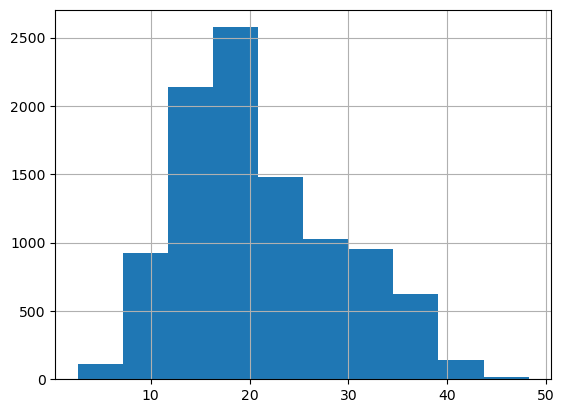

In [8]:
df.cost_of_the_order.hist()

# 2. Дизайн теста <a class="anchor" id="2"></a>

## Система сплитования <a class="anchor" id="2_1"></a>

Сделаем систему сплитования с помощью хэширования с солью, пользователи с четным хэшом будут в контрольной группе, с нечетным во второй

In [9]:
def split(id, salt='ab_test', n_groups=2 ):
    test_id = str(id) + '-' + str(salt) # добавляем к id соль
    return hash(test_id)%n_groups # делаем хэш и берем остаток от деления

In [10]:
df['group'] = df.customer_id.apply(split)

In [11]:
df.group.value_counts()


1    5006
0    4994
Name: group, dtype: int64

Распределяет более-менее равномерно

In [12]:
df[df.group==1].cost_of_the_order.mean(),df[df.group==0].cost_of_the_order.mean()

(21.233958526541766, 20.849998873771465)

Средние также примерно равны

## Расчет минимального размера выборки <a class="anchor" id="2_2"></a>

Вычисления будут проводиться по следующей формуле:

$$n > \dfrac{\left[ \Phi^{-1} \Bigl( 1-\dfrac{\alpha}{2} \Bigr) + \Phi^{-1} \Bigl( 1-\beta \Bigr) \right]^2 (\sigma_A^2 + \sigma_B^2)}{\varepsilon^2}$$

Где: <br>
n - размер выборки <br>
$\sigma$ - сигма соответствующей выборки <br>
$\varepsilon$ - минимальный эффект <br>
$\alpha$ - вероятность ошибки первого рода <br>
$\beta$ - вероятность ошибки второго рода <br>
$\Phi^{-1} ()$- соответствующий квантиль нормального распределения <br>

In [13]:

def get_sample_size(e, std, alpha=0.05, beta=0.2):
    z_alpha = sps.norm.ppf(1 - alpha / 2, loc=0, scale=1) # считаем квантили
    z_beta = sps.norm.ppf(1 - beta, loc=0, scale=1)
    square = (z_alpha + z_beta) ** 2 
    sample_size = int(
        np.ceil(
            square * (2 * std ** 2) / (e ** 2) # будем считать что дисперсии выборок одинаковые
        )
    )
    return sample_size

Также из этой формулы выведем mde

In [14]:

def get_mde(sample_size, std, alpha=0.05, beta=0.2):
    z_alpha = sps.norm.ppf(1 - alpha / 2, loc=0, scale=1)
    z_beta = sps.norm.ppf(1 - beta, loc=0, scale=1)
    disp_sum_sqrt = (2 * (std ** 2)) ** 0.5
    mde = (z_alpha + z_beta) * disp_sum_sqrt / np.sqrt(sample_size)
    return mde

Посчитаем необходимый нам размер 

In [15]:
metric = df.cost_of_the_order.mean() # метрика
std = df.cost_of_the_order.std() # сигма метрики
effect = metric*0.03 # наш минимальный эффект
sample_size = get_sample_size(effect,std)
sample_size

2583

## AA-тест <a class="anchor" id="2_3"></a>

Чтобы проверить насколько корректно работает сплитование и расчет выборки проведем AA тесты. В качестве статистического метода будет использовать обычный t-тест

  5%|████▏                                                                           | 53/1000 [00:04<01:00, 15.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:42<00:00, 23.74it/s]


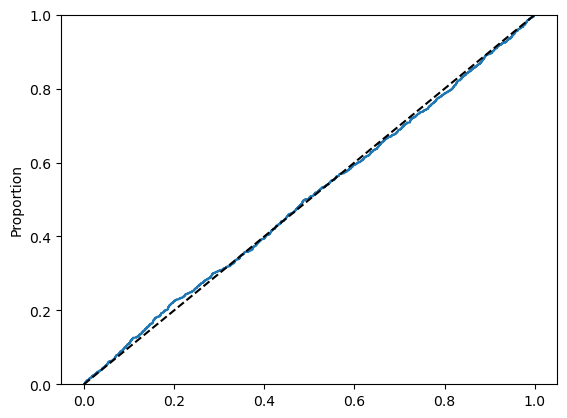

In [16]:
salt = '-experiment'
count = 1000
results_AA = [0 for _ in range(count)]
for i in tqdm(range(count)):
    sample = df.sample(2*sample_size) # берем необходимый сэмпл из выборки
    sample['group'] = sample.customer_id.apply(split, salt = str(i)+salt) # разделяем пользователей с новой солью
    a1 = sample[sample.group == 0].cost_of_the_order # берем знаения метрики из первой и второй группы
    a2 = sample[sample.group == 1 ].cost_of_the_order 
    _, p = sps.ttest_ind(a1, a2) 
    results_AA[i] = p
sns.ecdfplot(results_AA).plot([0,1],[0,1], 'k--')

Pvalue распределен довольно равномерно, посмотрим какая получилась альфа

In [17]:
sum([i<0.05 for i in results_AA])/1000 # Суммируем все значения pvalue<0.05 и делим на общеее количество

0.052

На ожидаемом уровне, посмотрим как это повлияет на АБ-тесты

## AB тест <a class="anchor" id="2_4"></a>

  2%|█▎                                                                              | 16/1000 [00:00<00:35, 27.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:37<00:00, 26.78it/s]


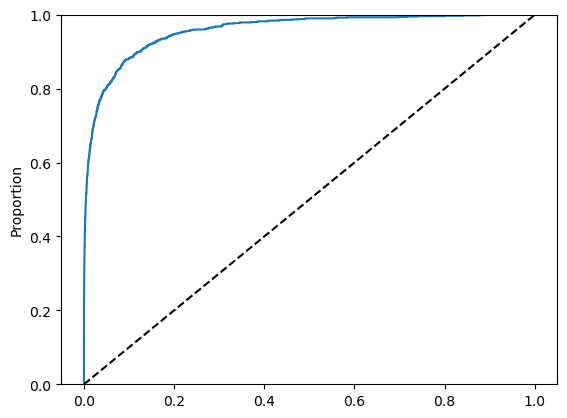

In [49]:
mu = df.cost_of_the_order.mean()
std = df.cost_of_the_order.std()
mde = mu*0.03
sample_size = get_sample_size(mde,std)
count = 1000
results_AB = [0 for _ in range(count)]
for i in tqdm(range(count)):
    sample = df.sample(2*sample_size)
    sample['group'] = sample.customer_id.apply(split, salt = str(i)+salt)
    a = sample[sample.group == 0].cost_of_the_order
    b = sample[sample.group == 1].cost_of_the_order
    b+=mde
    _, p = sps.ttest_ind(a, b)
    results_AB[i] = p
sns.ecdfplot(results_AB).plot([0,1],[0,1], 'k--')

In [50]:
sum([i<0.05 for i in results_AB])/1000

0.803

Все хорошо, мощность на ожидаемом уровне, значит все работает корректно

Проводить тест мы будем неделю, чтобы избежать сезонных искажений. Соответственно, итоговый размер каждой выборки составит примерно

In [47]:
daily_orders*7/2

2499.0

In [51]:
sample_size # размер выборки, который посчитала функция

2583

Совсем немного не хватает, но это не критично, так как мы можем использовать техники понижения дисперсии метрики, чтобы увеличить мощность и/или понизить необходимое количество наблюдений, сейчас одну из них и разберем

## Cuped <a class="anchor" id="2_5"></a>

Эта техника основана на использовании дополнительной метрики, которая коррелирует с главной. <br>
Для этого нам нужно сделать преобразование нашей метрики по формуле:

$$\hat{Y}_{CUPED} = \overline{Y} - \theta \overline{X} + \theta\mathbb{E}X$$

X - метрика коррелирующая с ключевой <br>
$\theta$ - специальный параметр, при котором дисперсия cuped метрики достигает минимальных значений

Формула для оптимального значения $\theta$:

$$\theta = \frac{\mathrm{cov}(Y,X)}{\mathbb{V} X}$$

Чтобы получить показатель, коррелирующий с ключевой метрикой, можно, например, взять ту же ключевую метрику двухнедельной давности. <br> 
Но сейчас я для примера ее просто сгенерирую

In [20]:
def generate_data(df,corr=0.6):
    x = df.cost_of_the_order
    y = df.sample(df.cost_of_the_order.count(),  # берем сэмпл данных из оригинальной выборки и немного рандомизируем
                   replace=True).cost_of_the_order+np.random.normal(0,2, size = df.cost_of_the_order.count())
    y = y.to_list()
    x = [[x[i],y[i]] for i in range(len(x))] # создаем одну матрицу с двумя столбцами
    corr_mat = np.array([ # создаем матрицу с нужной корреляцией
        [1.0, corr],
        [corr, 1.0]]) 
    upper_chol = linalg.cholesky(corr_mat) # применяем разложение Холецкого
    y = np.dot(x, upper_chol) # считаем скалярное произведение полученных матриц
    df['cost_of_the_order'] = [i[0] for i in y] # помещаем значение каждой переменной в датафрейм
    df['covar'] = [i[1] for i in y]
    return df

In [21]:
df_new = generate_data(df,corr=0.5)

In [22]:
df_new[['cost_of_the_order','covar']].corr()

,cost_of_the_order,covar
cost_of_the_order,1.000000,0.482348
covar,0.482348,1.000000


Работает, отлично <br>
Теперь напишем функции, которые по формулам будут считать cuped-метрики

In [23]:
# Функцию которая нам будем сразу по формуле выводить значение theta
def get_theta(y_control, y_test, x_control, x_test):
    y = np.hstack([y_control, y_test])
    x = np.hstack([x_control, x_test])
    covariance = np.cov(x, y)[0, 1] # cчитаем ковариацию
    variance = x.var() # cчитаем дисперсию ковариаты
    theta = covariance / variance
    return theta

# Функцию которая автоматически будем проводить t-тест и выдавать pvalue
def check_test(df_control, df_test, metric): 
    values_control = df_control[metric].values
    values_test = df_test[metric].values
    _, pvalue = sps.ttest_ind(values_control, values_test)
    return pvalue

# Функция считает cuped метрики и проводит t-тест
def check_cuped_test(df_control, df_test,metric, metric_before):
    theta = get_theta(
        df_control[metric], df_test[metric],
        df_control[metric_before], df_test[metric_before]
    )
    # посчитаем по формуле значение cuped метрик в контроле и в тесте
    metric_cuped_control = df_control[metric] - theta * df_control[metric_before]
    metric_cuped_test = df_test[metric] - theta * df_test[metric_before]
    _, pvalue = sps.ttest_ind(metric_cuped_control, metric_cuped_test)
    return pvalue


Посмотрим как это работает на практике. Начнем c АА теста

In [24]:
corr = 0.7 # задаем корреляцию
df_new = generate_data(df,corr=0.7) # генерим данные
mu = df_new.cost_of_the_order.mean() # считаем среднее и сигму получившихся значений
std = df_new.cost_of_the_order.std() 

sample_size = get_sample_size(mde,std) # находим размер выборки
count = 1000

# Создадим массивы куда будем заносить получившиеся pvalue
pvalues = [0 for i in range(count)]
pvalues_cuped = [0 for i in range(count)]
for i in tqdm(range(count)):
    sample = df.sample(2*sample_size).copy()
    sample['group'] = sample.customer_id.apply(split, salt = str(i)+salt)
    a1 = sample[sample.group == 0]
    a2 = sample[sample.group == 1 ]
    pvalue = check_test(a1,a2,'cost_of_the_order')
    pvalue_cuped = check_cuped_test(a1,a2,'cost_of_the_order','covar')
    pvalues[i] = pvalue
    pvalues_cuped[i] = pvalue_cuped

  3%|██▌                                                                             | 32/1000 [00:01<00:53, 18.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:41<00:00, 24.02it/s]


Построим графики расределения pvalue

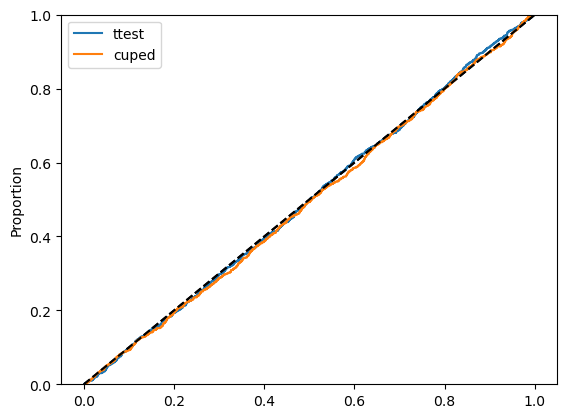

In [25]:
sns.ecdfplot(pvalues, label = 'ttest').plot([0,1],[0,1], 'k--')
sns.ecdfplot(pvalues_cuped, label = 'cuped').plot([0,1],[0,1], 'k--')
plt.legend()

Видно что Cuped-метрика имеет такое же равномерное распределение pvalue как и у t-теста, ну а теперь посмотрим что у нее с мощностью

In [26]:

mde = mu*0.03 # минимальный эффект 3%
count = 1000


pvalues = [0 for i in range(count)]
pvalues_cuped = [0 for i in range(count)]
for i in tqdm(range(count)):
    sample = df.sample(2*sample_size)
    sample['group'] = sample.customer_id.apply(split, salt = str(i)+salt)
    a = sample[sample.group == 0].copy()
    b = sample[sample.group == 1 ].copy()
    b.cost_of_the_order+=mde
    pvalue = check_test(a,b,'cost_of_the_order')
    pvalue_cuped = check_cuped_test(a,b,'cost_of_the_order','covar')
    pvalues[i] = pvalue
    pvalues_cuped[i] = pvalue_cuped

  0%|▎                                                                                | 4/1000 [00:00<01:06, 15.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:51<00:00, 19.42it/s]


Строим графики

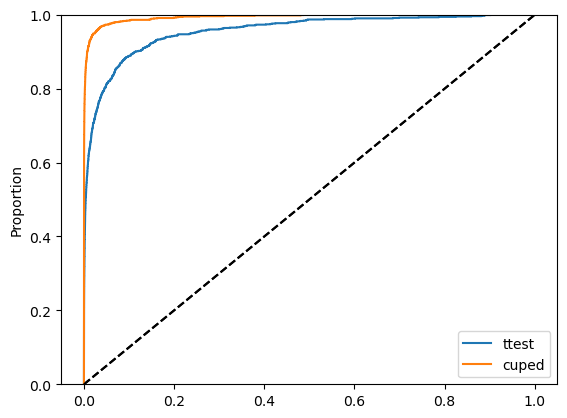

In [27]:
sns.ecdfplot(pvalues, label = 'ttest').plot([0,1],[0,1], 'k--')
sns.ecdfplot(pvalues_cuped, label = 'cuped').plot([0,1],[0,1], 'k--')
plt.legend()

Видно, что мощность действительно повысилась, посмотрим насколько

In [28]:
sum([i<0.05 for i in pvalues])/1000

0.811

In [29]:
sum([i<0.05 for i in pvalues_cuped])/1000

0.973

Неплохой прирост. Так как цель этого метода в понижении дисперсии, сейчас посмотрим на сколько процентов снижается дисперсия в зависимости от значений корелляции

## Проверка изменения дисперсии

In [30]:
corrs = [i/10 for i in range(1,10)] #  сделаем массим занчений корреляции от 0.1 до 0.9

# создадим массивы куда будем помещать полученные значения
real_corr = []
var_reduc = []
for c in tqdm(corrs):
    df_new = generate_data(df,corr=c) 
    df_new['group'] = df_new.customer_id.apply(lambda x: split(x,salt='-cuped_test'))

    var_1 = df_new.cost_of_the_order.var(ddof=1) # считаем дисперсию ключевой метрики
    corr = df_new[['cost_of_the_order','covar']].corr().iloc[0,1] # берем значение корреляции которое по-факту получилось сгенерировать
    var_2 = round(var_1*(1-corr**2),2) # считаем дисперсию cuped метрики по формуле (формула взята из доклада Валеры Бабушкина) 
    real_corr.append(round(corr,2))
    var_reduc.append(round((var_1-var_2)/var_1*100,2))

 11%|█████████▎                                                                          | 1/9 [00:01<00:09,  1.18s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.54it/s]


<AxesSubplot:>

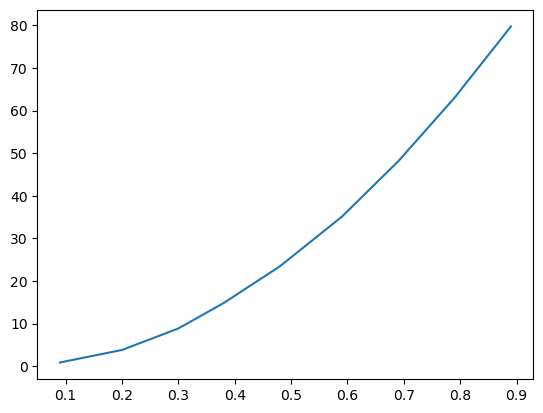

In [31]:
sns.lineplot(x = real_corr,y=var_reduc)

Видно что после 0.4 начинаются самые большие темпы роста, <br>
а при корреляции в 0.9 можно добиться сокращения дисперсии аж на 80% <br>
Теперь посчитаем как благодаря этому изменяется необходимый размер выборки


## Влияние на Размер выборки

In [32]:
corrs = [i/10 for i in range(1,10)]
mde = df.cost_of_the_order.mean()*0.03

real_corr = []
sizes = []
for c in tqdm(corrs):
    df_new = generate_data(df,corr=c)
    df_new['group'] = df_new.customer_id.apply(lambda x: split(x,salt='-cuped_test'))
    var_1 = df_new.cost_of_the_order.var(ddof=1)
    corr = df_new[['cost_of_the_order','covar']].corr().iloc[0,1]
    var_2 = round(var_1*(1-corr**2),2)
    sample_size = get_sample_size(e = mde, std = var_2**(1/2)) # считаем размер выборки но уже для дисперсии cuped метрики
    real_corr.append(round(corr,2))
    sizes.append(sample_size)

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.93it/s]


<AxesSubplot:>

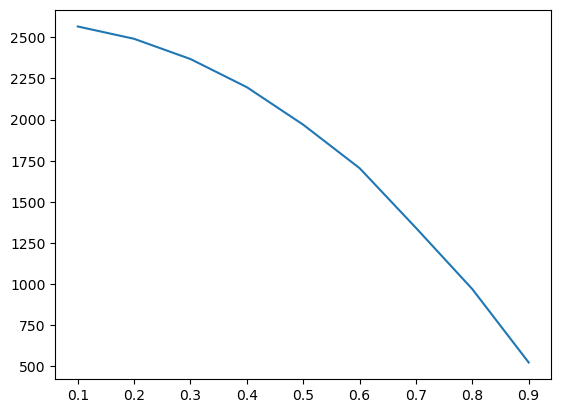

In [33]:
sns.lineplot(x = corrs,y=sizes)

Хорошая динамика. Судя по графику при корреляции в 0.7 мы можем добиться требуемой мощности с выборкми размером около 1250 пользователей, сейчас это проверим

In [34]:
print(f'А точнее {sizes[-3]} пользователя')

А точнее 1342 пользователя


In [35]:

corr = 0.7
df_new = generate_data(df=df,corr=corr) 

mu = df_new.cost_of_the_order.mean()
mde = mu*0.03
sample_size = sizes[-3] # берем размер выборки из прошлого массива
count = 1000

pvalues = [0 for i in range(count)]
pvalues_cuped = [0 for i in range(count)]
for i in tqdm(range(count)):
    sample = df.sample(2*sample_size)
    sample['group'] = sample.customer_id.apply(split, salt = str(i)+salt)
    a = sample[sample.group == 0].copy()
    b = sample[sample.group == 1 ].copy()
    b['cost_of_the_order']+=mde
    pvalue = check_test(a,b,'cost_of_the_order')
    pvalue_cuped = check_cuped_test(a,b,'cost_of_the_order','covar')
    pvalues[i] = pvalue
    pvalues_cuped[i] = pvalue_cuped

  0%|▎                                                                                | 4/1000 [00:00<01:17, 12.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 30.56it/s]


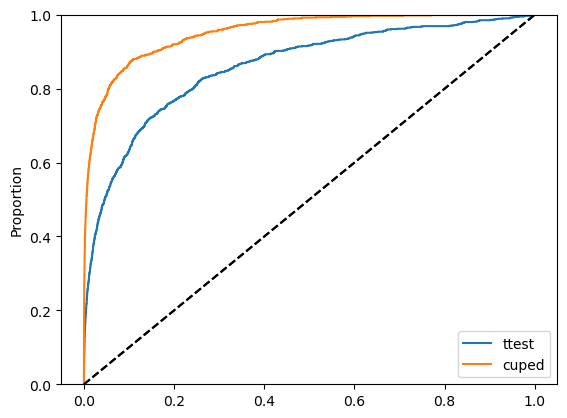

In [36]:
sns.ecdfplot(pvalues, label = 'ttest').plot([0,1],[0,1], 'k--')
sns.ecdfplot(pvalues_cuped, label = 'cuped').plot([0,1],[0,1], 'k--')
plt.legend()

In [37]:
sum([i<0.05 for i in pvalues])/1000

0.512

In [38]:
sum([i<0.05 for i in pvalues_cuped])/1000

0.781

Мощность действительно осталась практически такой же. Таким образом благодаря Cuped можно сократить практически в два раза требуемый размер выборки

## Проверка итоговых параметров теста

Теперь посчитаем мощность для размера выборки, который мы получим после недели эксперимента

In [52]:

sample_size = int(daily_orders*7/2)
mu = df_new.cost_of_the_order.mean()
mde = mu*0.03
count = 1000

pvalues = [0 for i in range(count)]
pvalues_cuped = [0 for i in range(count)]
for i in tqdm(range(count)):
    sample = df.sample(2*sample_size)
    sample['group'] = sample.customer_id.apply(split, salt = str(i)+salt)
    a = sample[sample.group == 0].copy()
    b = sample[sample.group == 1 ].copy()
    b['cost_of_the_order']+=mde
    pvalue = check_test(a,b,'cost_of_the_order')
    pvalue_cuped = check_cuped_test(a,b,'cost_of_the_order','covar')
    pvalues[i] = pvalue
    pvalues_cuped[i] = pvalue_cuped

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:56<00:00, 17.86it/s]


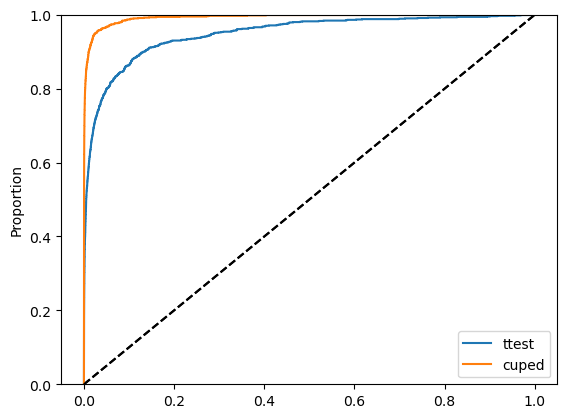

In [53]:
sns.ecdfplot(pvalues, label = 'ttest').plot([0,1],[0,1], 'k--')
sns.ecdfplot(pvalues_cuped, label = 'cuped').plot([0,1],[0,1], 'k--')
plt.legend()

In [54]:
sum([i<0.05 for i in pvalues_cuped])/1000

0.967

# Итоги <a class="anchor" id="3"></a>
- Мы создали систему сплитования пользователей
- Вычислили необходимый размер выборок
- С помощью синтетических тестов проверили корректность созданного дизайна
- Применили методику повышения чувствительности тестов Cuped, чтобы повысить мощность итогового теста

## Результат
Длительность АБ-теста составит 1 неделю, чтобы избежать сезонных отклонений (также желательно проследить, чтобы в эту неделю не было никаких праздников), мы распределяем пользователей на группы с помощью хэширования с солью их айдишников, по истечению необходимого периода времени мы с помощью t-теста подсчитаем  pvalue получившихся значений cuped-метрики, если pvalue окажется меньше 0.05, то отвергаем гипотезу о равенстве метрик.  Вероятности совершить ошибку первого и второго рода составят 5% и ~4% соответственно. <br>


Также важно следить за другими ключевыми метриками компании, например за средним количеством заказов в день, чтобы в итоге понимать, оказался ли общий trade-off по метрикам положительным.
